jupyter nbconvert mv_kecdf_frechet.ipynb --to slides --post serve

In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spst
import statsmodels.api as sm
from scipy import optimize

from statsmodels.nonparametric import kernels


kernel_func = dict(wangryzin=kernels.wang_ryzin,
                   aitchisonaitken=kernels.aitchison_aitken,
                   gaussian=kernels.gaussian,
                   aitchison_aitken_reg = kernels.aitchison_aitken_reg,
                   wangryzin_reg = kernels.wang_ryzin_reg,
                   gauss_convolution=kernels.gaussian_convolution,
                   wangryzin_convolution=kernels.wang_ryzin_convolution,
                   aitchisonaitken_convolution=kernels.aitchison_aitken_convolution,
                   gaussian_cdf=kernels.gaussian_cdf,
                   aitchisonaitken_cdf=kernels.aitchison_aitken_cdf,
                   wangryzin_cdf=kernels.wang_ryzin_cdf,
                   d_gaussian=kernels.d_gaussian)

def gpke(bwp, dataxx, data_predict, var_type, ckertype='gaussian',
         okertype='wangryzin', ukertype='aitchisonaitken', tosum=True):
    r"""Returns the non-normalized Generalized Product Kernel Estimator"""
    kertypes = dict(c=ckertype, o=okertype, u=ukertype)
    Kval = np.empty(dataxx.shape)
    for ii, vtype in enumerate(var_type):
        func = kernel_func[kertypes[vtype]]
        Kval[:, ii] = func(bwp[ii], dataxx[:, ii], data_predict[ii])

    iscontinuous = np.array([c == 'c' for c in var_type])
    dens = Kval.prod(axis=1) / np.prod(bwp[iscontinuous])
    #dens = np.nanprod(Kval,axis=1) / np.prod(bwp[iscontinuous])
    if tosum:
        return dens.sum(axis=0)
    else:
        return dens


class LeaveOneOut(object):
    def __init__(self, X):
        self.X = np.asarray(X)

    def __iter__(self):
        X = self.X
        nobs, k_vars = np.shape(X)

        for i in range(nobs):
            index = np.ones(nobs, dtype=np.bool)
            index[i] = False
            yield X[index, :]



def loo_likelihood(bww, datax, var_type, func=lambda x: x, ):
    #print(bww)
    LOO = LeaveOneOut(datax)
    L = 0
    for i, X_not_i in enumerate(LOO):
        f_i = gpke(bww, dataxx=-X_not_i, data_predict=-datax[i, :],
                   var_type=var_type)
        L += func(f_i)
    return -L


def get_bw(datapfft ,var_type ,reference):
    # Using leave-one-out likelihood
    # the initial value for the optimization is the normal_reference
    # h0 = normal_reference()

    data = adjust_shape(datapfft, len(var_type))

    h0 =reference
    fmin =lambda bb, funcx: loo_likelihood(bb, data, var_type, func=funcx)
    bw = optimize.fmin(fmin, x0=h0, args=(np.log, ),
                       maxiter=1e3, maxfun=1e3, disp=0, xtol=1e-3)
    # bw = self._set_bw_bounds(bw)  # bound bw if necessary
    return bw

def adjust_shape(dat, k_vars):
    """ Returns an array of shape (nobs, k_vars) for use with `gpke`."""
    dat = np.asarray(dat)
    if dat.ndim > 2:
        dat = np.squeeze(dat)
    if dat.ndim == 1 and k_vars > 1:  # one obs many vars
        nobs = 1
    elif dat.ndim == 1 and k_vars == 1:  # one obs one var
        nobs = len(dat)
    else:
        if np.shape(dat)[0] == k_vars and np.shape(dat)[1] != k_vars:
            dat = dat.T

        nobs = np.shape(dat)[0]  # ndim >1 so many obs many vars

    dat = np.reshape(dat, (nobs, k_vars))
    return dat

%alias_magic t timeit

# Data science friday tales:
### Using Fréchet Bounds for Bandwidth selection in MV Kernel Methods.

#### Lia Silva-Lopez

---

*Tuesday, 19/03/2019*

## This story starts with a reading accident
---

#### One moment you are reading a book...

<img src="img/reading_accident.png">

#### ...And the next there are bounds for everything.

## Bounds for distributions* in terms of its marginals?
---

* That makes perfect sense!

* Why aren't these bounds more mainstream? 

* Is it because it's hard to pronounce 'Fréchet'?

*_with distributions we mean CDFs, not densities_

## Allright, let's point the fingers at ourselves:
---

## What would **I** do with Fréchet bounds?


'Cause the *whole point* of bounds is to try **_not_** to break them. Right?


<img src="https://media3.giphy.com/media/145lrrvcdNq43m/source.gif" style="width: 280px;">

## An idea: Let's use them for Bandwidth selection in MV KDEs.
---

* MV kernel estimation is expensive, slow and often hard to check with d>2.


* Which is why Kernel methods are recommended for smoothing (mostly).


* However, working with multivariate is not easy.
    * So a lot of people turn to KDEs in the lack of better information.
    * Or, throw samples at a blackbox and hope for the best.

## How can we use Fréchet bounds here?
---

There are different methods for BW selection, many based on some kind of optimization.

* To prune the search space on any iterative method:
    * (Naive) Removing bws that lead to estimates violating the bounds.
    * (Less naive, but less parsinomic) prune using thresholds.
    

* To construct functions to optimize over:
    * (Cheap, uninformative) Counting the number of violations of the bound?
    * (Cheap, informative) Summing all diffs between each violation and the bound point?

## Other questions to answer:
---

* Are we breaking Fréchet bounds when estimating CDFs with Kernels?

    * And if we break them, 
        * How _badly_ are they usually broken?
        * Do they get broken often?
    

* What are the consequences of selecting BWs that lead to breaking Fréchet?

<img src="https://memegenerator.net/img/instances/63332969/do-all-the-things.jpg" style="width: 70%;">

## What's in Python for this?
---

* Scikit-Learn, Scipy, StatsModels are the usual suspects.


* Only StatsModels has a convenience method to estimate CDFs with use Kernels.


* Based solely on making my life easy, I chose StatsModels to hack MV KDE methods and insert Fréchet bounds in BW estimation.

## StatsModels KDEMultivariate Package
---

* Wrapper code for MV KDE [here](https://www.statsmodels.org/dev/_modules/statsmodels/nonparametric/kernel_density.html#KDEMultivariate)


* Base code for bandwith selection methods [here](https://www.statsmodels.org/dev/_modules/statsmodels/nonparametric/_kernel_base.html).


## Let's have a quick overview for how this _normally_ works.

## First we generate some data to call the methods.
---

#### We will use some betas.


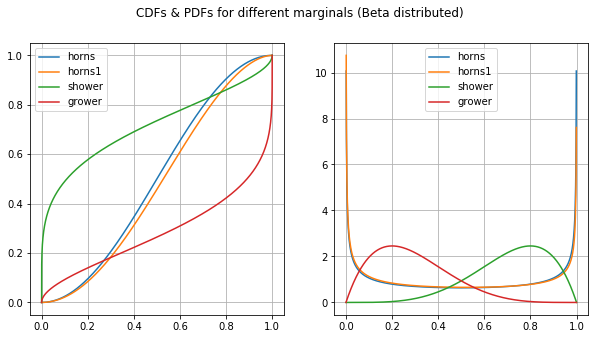

In [18]:
n=1000
distr=spst.beta #<-- From SciPy
smpl=np.linspace(0,1,num=n)
params={'horns':(0.5,0.5),'horns1':(0.5,0.55),
        'shower':(5.,2.),'grower':(2.,5.)}

v_type=f'{"c"*len(params)}' #<-- Statsmodels wants to know if data is 
                            # continuous (c) 
                            # discrete ordered (o) 
                            # discrete unordered (u)
    
fig, ax = plt.subplots(1,2,figsize=(10,5))
list(map(lambda x: ax[0].plot(distr.cdf(smpl,*x),smpl) , params.values()))
list(map(lambda x: ax[1].plot(smpl,distr.pdf(smpl,*x)) , params.values()))
ax[0].legend(list(params.keys()));ax[1].legend(list(params.keys()))
ax[0].grid(); ax[1].grid() 
fig.suptitle(f'CDFs & PDFs for different marginals (Beta distributed)')
plt.show()

## Kernels and BW Selection Methods
---

#### Kernel selection depends on "v_type". For "c" -> Gaussian Kernel. 

This is a list of the kernel functions available in the package

kernel_func = dict(
                    
                   wangryzin=kernels.wang_ryzin,
                   aitchisonaitken=kernels.aitchison_aitken,
                   gaussian=kernels.gaussian,
                   
                   aitchison_aitken_reg = kernels.aitchison_aitken_reg,
                   wangryzin_reg = kernels.wang_ryzin_reg,
                   
                   gauss_convolution=kernels.gaussian_convolution,
                   wangryzin_convolution=kernels.wang_ryzin_convolution,
                   aitchisonaitken_convolution=kernels.aitchison_aitken_convolution,
                   
                   gaussian_cdf=kernels.gaussian_cdf,
                   aitchisonaitken_cdf=kernels.aitchison_aitken_cdf,
                   wangryzin_cdf=kernels.wang_ryzin_cdf,
                   
                   d_gaussian=kernels.d_gaussian)


Different kernels are selected for different reasons: variable features and if they want to fit pdfs or cdfs.

(probably)

#### Bandwidth selection methods

We have a choice of 3 BW selection methods:


##### 1. normal_reference: normal reference rule of thumb (default) 
* BW from this method is the starting point of the other two algorithms
* Silverman's rule for MV case
* Quick, but too smooth.


##### 2. cv_ml: cross validation maximum likelihood


* Not quick, but reasonable estimates in reasonable time (within seconds to few minutes).


Uses the bandwidth estimate that maximizes the leave-out-out likelihood.  


* Implemented in method ["_cv_ml(self)" of "class GenericKDE(object)" in "statsmodels.nonparametric._kernel_base"](https://www.statsmodels.org/dev/_modules/statsmodels/nonparametric/_kernel_base.html)


* The leave-one-out log likelihood function is:

$$\ln L=\sum_{i=1}^{n}\ln f_{-i}(X_{i})$$


* The leave-one-out kernel estimator of $f_{-i}$ is:

$$f_{-i}(X_{i})=\frac{1}{(n-1)h} \sum_{j=1,j\neq i}K_{h}(X_{i},X_{j})$$

where $K_{h}$ represents the Generalized product kernel estimator:

$$ K_{h}(X_{i},X_{j})=\prod_{s=1}^{q}h_{s}^{-1}k\left(\frac{X_{is}-X_{js}}{h_{s}}\right) $$


* The Generalized product Kernel Estimator is also a method of GenericKDE(object).


##### 3. cv_ls: cross validation least squares

* Very, very slow (>8x times slower than ml)

Returns the value of the bandwidth that maximizes the integrated mean square error between the estimated and actual distribution.

* Implemented in method ["_cv_ls(self)" of "class GenericKDE(object)" in "statsmodels.nonparametric._kernel_base"](https://www.statsmodels.org/dev/_modules/statsmodels/nonparametric/_kernel_base.html)

The integrated mean square error (IMSE) is given by:

$$ \int\left[\hat{f}(x)-f(x)\right]^{2}dx $$

## Comparing times and bandwidth choices

Let's compare times and values for bandwidth selection for each method available in StatsModels, considering **4 dimensions** and **1000 samples**.

* Rule-of-thumb:
3 loops, best of 3: **109 µs per loop**
bw with reference [0.15803504 0.15817752 0.07058083 0.07048409]


* CV-LOO ML: 
3 loops, best of 3: **1min 39s per loop**
bw with maximum likelihood [0.04915534 0.03477012 0.09889865 0.09816758]


* CV-LS:
3 loops, best of 3: **12min 30s per loop**
bw with least squares [1.12156416e-01 1.00000000e-10 1.03594669e-01 9.11747124e-02]


#### But, check out the bandwidths sizes!

In [20]:
import statsmodels.api as sm

#Generate some independent data for each parameter set
mvdata={k:distr.rvs(*params[k],size=n) for k in params}
rd=np.array(list(mvdata.values()))

%timeit -n3 sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='normal_reference')
dens_u_rot = sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='normal_reference')
print('bw with reference',dens_u_rot.bw, '(only available for gaussian kernels)')

%timeit -n3 sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='cv_ml')
dens_u_ml = sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='cv_ml')
print('bw with maximum likelihood',dens_u_ml.bw)

# BW with least squares takes >8x more than with ml
%timeit -n3 sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='cv_ls')
dens_u_ls = sm.nonparametric.KDEMultivariate(data=rd,var_type=v_type, bw='cv_ls')
print('bw with least squares',dens_u_ls.bw)

3 loops, best of 3: 109 µs per loop
bw with reference [0.15803504 0.15817752 0.07058083 0.07048409] (only available for gaussian kernels)


/home/lia/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernel_density.py:161: RuntimeWarning: invalid value encountered in log
  L += func(f_i)


3 loops, best of 3: 1min 39s per loop
bw with maximum likelihood [0.04915534 0.03477012 0.09889865 0.09816758]
3 loops, best of 3: 12min 30s per loop
bw with least squares [1.12156416e-01 1.00000000e-10 1.03594669e-01 9.11747124e-02]


## Now the fun part: modifying the package to do our bidding
---

* All we need is in two classes: [class KDEMultivariate(GenericKDE)](https://www.statsmodels.org/dev/_modules/statsmodels/nonparametric/kernel_density.html#KDEMultivariate) and its parent, [class GenericKDE(object)](https://www.statsmodels.org/dev/_modules/statsmodels/nonparametric/_kernel_base.html).


* When we call the constructor for the KDEMultivariate object, this happens:
    * Data checks & reshaping, internal stuff settings.
    * Bandwidth selection function method is chosen and bandwidth is calculated by doing a call to a hidden parent method (`self._compute_bw(bw)` or `self._compute_efficient(bw)`)
    

* At the parent method, either one of this methods of the parent called:
    * `_normal_reference()` <- Silverman's rule
    * `_cv_ml()` <- Cross validation maximum likelihood
    * `_cv_ls()` <- Cross validation least squares

## How do the BW calculation methods work?
---

`_cv_ml()` and `_cv_ls()` are **almost** the same method except for:

| `_cv_ml()`  |  `_cv_ls()` |
|---|---|
|  h0 = self._normal_reference() | h0 = self._normal_reference() |
|bw = optimize.fmin(**self.loo_likelihood,** | bw = optimize.fmin(**self.imse,**|
|x0=h0, **args=(np.log, ),**|  x0=h0,| 
|maxiter=1e3, | maxiter=1e3 |
|maxfun=1e3, | maxfun=1e3, |
|disp=0, | disp=0,|
|xtol=1e-3) | xtol=1e-3) |


* A bummer: no direct way to feed ranges of hyperparameters in order to constrain the search space!

    * They simply call scipy.optimize.fmin underneath.


##### `optimize.fmin` comes from [scipy.optimize](https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.optimize.fmin.html#scipy.optimize.fmin)

## So everything is passed to an optimization function!
---

Pretty much. 


Doesn't mean we can't do something about it :).


Let's look inside `loo_likelihood`, and see where can we intervene:    

In [43]:
def loo_likelihood(self, bw, func=lambda x: x):

    LOO = LeaveOneOut(self.data) #<- iterator for a leave-one-out over the data
    L = 0
    for i, X_not_i in enumerate(LOO): #<- per leave-one-out of the data (ouch!)
        
        f_i = gpke(bw, #<- provided by the optimization algorithm 
        
                   data=-X_not_i, #<- dataset minus one sample as given by LOO
                   
                   data_predict=-self.data[i, :], #<- REAL dataset, ith point
                   
                   var_type=self.var_type) #<- 'cccc' or something similar
        
        L += func(f_i) #<- _cv_ml() passed np.log, so its log-likelihood 
                       # of gkpe at ith point.
    
    return -L

## What happens inside gkpe?
---

* Both the CDF and PDF are estimated with a gpke. They just use a different kernel.


* All the kernel implementations are [here](https://github.com/statsmodels/statsmodels/blob/master/statsmodels/nonparametric/kernels.py).

In [ ]:
def gpke(bw, data, data_predict, var_type, ckertype='gaussian',
         okertype='wangryzin', ukertype='aitchisonaitken', tosum=True):
    
    kertypes = dict(c=ckertype, o=okertype, u=ukertype) #<- kernel selection

    Kval = np.empty(data.shape)
    for ii, vtype in enumerate(var_type): #per ii dimension
        func = kernel_func[kertypes[vtype]]
        Kval[:, ii] = func(bw[ii], data[:, ii], data_predict[ii]) 

    iscontinuous = np.array([c == 'c' for c in var_type])
    dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous]) #<- Ta-da, kernel products.
    if tosum:
        return dens.sum(axis=0)
    else:
        return dens

# What did I do?

## Groundwork:
---

Methods for: 


* Estimating the Fréchet bounds for a dataset.


* Visualizing the bounds (2d datasets) [see here](https://github.com/lia-statsletters/notebooks/blob/master/Frechet.ipynb)


* Counting how many violations of the bound were made by a CDF.


* Measuring the size of the violation at each point (diff between the point of the CDF in which the violation happened, and the bound that was broken)


* Generating experiments


* Massaging outputs of the profiler

## Then...
---

* Estimated a percentage of bound breaking for winning bandwidths in different methods.
    * It was not zero!!!


* Tried using the violations as a way to prune "unpromising" bandwidths before applying the gpke thru the whole LOO iteration.

    * It made the optimization algorithm go coo-coo

    * Because scipy.optimize.fmin was expecting a number out of that function.

    * To return something "proportionally punishing", I probably should keeping track of the previous estimates.

    * That would require more work.

        * Basically also hacking the code for the optimization.
        * Future work!

## Then more...
---

#### Hijacked loo_likelihood() to make my own method in which violations are used to guide the optimization algorithm.

* Tried feeding number of violations to the algorithm. 

    * The algorithm got lost.
    
    * Maybe too little information?
        
   
* Tried feeding the sum of the size of all violations. 

    * It kinda worked but the final steps of the algorithm were unstable.
    
    * Can we make it a bit more informative?
        

## And then, some more.
---        
* Tried feeding a weighted sum of the size of all violations.

    * The weights were the size of the bound at each violation point.

    * The rationale is that a violation at a narrow point should be punished more than a violation at an already wide point.
    
    * It still takes between 20% to 200% more time than cv_ml when it should be at least an order of magnitude faster (cdf estimation is faster than leave-one-out)
    
    * **Gee, I wonder if I have a bug somewhere?**

# Yup, I actually had a bug.
---

## What was the bug?
---

* While making this presentation I realized I had a bug.


* My method for estimating bounds should be called with **THE CDFs** of each dimension.
    * I was calling it with the data directly (!!!).


* No wonder I was getting horrible results.


* So the actual results of this hack will have to wait :P.
    * All my tests of the weekend are now useless.
    * Will keep them somewhere in my hard-drive as mementos...

;D I will repeat the tests with the right call and show the results for the next presentation.

<img src="https://i.kym-cdn.com/photos/images/newsfeed/000/187/324/allthethings.png" style="width: 70%;">

## Ok, is not like everything is wrong
---

Let's do some quick counts here for Fréchet violations.

In [41]:
def get_frechets(dvars):
    d=len(dvars)
    n=len(dvars[0])
    dimx=np.array(range(d))
    un=np.ones(d,dtype=int)
    bottom_frechet = np.array([max( np.sum( dvars[dimx,un*i] ) +1-d, 0 ) 
                               for i in range(n) ])
    
    top_frechet = np.array([min([y[i] for y in dvars]) for i in range(n)])
    return {'top': top_frechet, 'bottom': bottom_frechet}

In [29]:
cdfs={fname :distr.cdf(smpl,*params[fname]) for fname in params}
frechets=get_frechets(np.array(list(cdfs.values())))

### Calculating number of violations

In [30]:
def check_frechet_fails(guinea_cdf,frechets):
    fails={'top':[], 'bottom':[]}
    for n in range(len(guinea_cdf)):
        #n_hyper_point=np.array([x[n] for x in rd])
        if guinea_cdf[n]>frechets['top'][n]:
            fails['top'].append(True)
        else:
            fails['top'].append(False)

        if guinea_cdf[n]<frechets['bottom'][n]:
            fails['bottom'].append(True)
        else:
            fails['bottom'].append(False)
    return {'top':np.array(fails['top']),
            'bottom':np.array(fails['bottom'])}


Given 4 dimensions and 1000 samples, we got:


* For Silverman: 58.8% violations

* For cv_ml: 58.0% violations

* For cv_ls: 57.0% violations


In [35]:
# For Silverman
violations_silverman=check_frechet_fails(dens_u_rot.cdf(),frechets)
violations_silverman=np.sum(violations_silverman['top'])+ np.sum(violations_silverman['bottom'])
print(f'violations:{violations_silverman} ({100.*violations_silverman/len(smpl)}%)')

violations:588 (58.8%)


In [36]:
# For cv_ml
violations_cv_ml=check_frechet_fails(dens_u_ml.cdf(),frechets)
violations_cv_ml=np.sum(violations_cv_ml['top'])+ np.sum(violations_cv_ml['bottom'])
print(f'violations:{violations_cv_ml} ({100.*violations_cv_ml/len(smpl)}%)')

violations:580 (58.0%)


In [40]:
# For cv_ls
violations_cv_ls=check_frechet_fails(dens_u_ls.cdf(),frechets)
violations_cv_ls=np.sum(violations_cv_ls['top'])+ np.sum(violations_cv_ls['bottom'])
print(f'violations:{violations_cv_ls} ({100.*violations_cv_ls/len(smpl)}%)')

violations:579 (57.9%)


## What more?
---

Quite a lot of sweat went into generating code for comparing my approaches with `cv_ml`

I may as well show it to you, and point where the bug was :(.

In [42]:
def generate_experiments(reps,n,params, distr, dims):
    bws_frechet={f'bw_{x}':[] for x in params}
    bws_cv_ml={f'bw_{x}':[] for x in params}


    for iteration in range(reps):
        mvdata = {k: distr.rvs(*params[k], size=n) for k in params}
        rd = np.array(list(mvdata.values())) #<---- THIS IS NOT A CDF!!!!!

        # get frechets and thresholds
        frechets = get_frechets(rd)  #<------- THEREFORE THIS IS A BUG !!!!!

        bw_frechets, bw_cv_ml=profile_run(rd, frechets,iteration)

        for ix,x in enumerate(params):
            bws_frechet[f'bw_{x}'].append(bw_frechets[ix])
            bws_cv_ml[f'bw_{x}'].append(bw_cv_ml[ix])

    pd.DataFrame(bws_frechet).to_csv(f'/home/lia/liaProjects/outs/bws_frechet_d{dims}-n{n}-iter{reps}.csv')
    pd.DataFrame(bws_cv_ml).to_csv(f'/home/lia/liaProjects/outs/bws_cv_ml_d{dims}-n{n}-iter{reps}.csv')

### And this is how the functions that make the calculations look underneath.
---

In [ ]:
def get_bw(datapfft, var_type, reference, frech_bounds=None):
    # Using leave-one-out likelihood
    # the initial value for the optimization is the normal_reference
    # h0 = normal_reference()

    data = adjust_shape(datapfft, len(var_type))

    if not frech_bounds:
        fmin =lambda bw, funcx: loo_likelihood(bw, data, var_type, func=funcx)
        argsx=(np.log,)
    else:
        fmin = lambda bw, funcx: frechet_likelihood(bw, data, var_type,
                                                    frech_bounds, func=funcx)
        argsx=(None,) #second element of tuple is if debug mode

    h0 = reference
    bw = optimize.fmin(fmin, x0=h0, args=argsx, #feeding logarithm for loo
                       maxiter=1e3, maxfun=1e3, disp=0, xtol=1e-3)
    # bw = self._set_bw_bounds(bw)  # bound bw if necessary
    return bw

### And this was my frechet_likelihood method
---

In [ ]:
def frechet_likelihood(bww, datax, var_type, frech_bounds, func=None, debug_mode=False,):
    
    cdf_est = cdf(datax, bww, var_type)  # <- calls gpke underneath, but is a short call
    
    d_violations = calc_frechet_fails(cdf_est, frech_bounds)
    
    width_bound = frech_bounds['top'] - frech_bounds['bottom']
    
    viols=(d_violations['top']+d_violations['bottom'])/width_bound
    
    L= np.sum(viols)
    return L

### And this is how profiling info was collected
---

The python profiler is a bit unfriendly, so maybe this code could be useful as a snippet?

Or, getting a professional license of pycharm ;) (Thanks boss!)

In [ ]:
def profile_run(rd,frechets,iterx):
    dims=len(rd)
    n=len(rd[0])
    v_type = f'{"c"*dims}'
    # threshold: number of violations by the cheapest method.
    dens_u_rot = sm.nonparametric.KDEMultivariate(data=rd, var_type=v_type, bw='normal_reference')
    cdf_dens_u_rot = dens_u_rot.cdf()
    violations_rot = count_frechet_fails(cdf_dens_u_rot, frechets)


    #profile frechets
    pr = cProfile.Profile()
    pr.enable()
    bw_frechets = get_bw(rd, v_type, dens_u_rot.bw, frech_bounds=frechets)
    pr.disable()

    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumtime')
    ps.print_stats()
    s = s.getvalue()

    with open(f'/home/lia/liaProjects/outs/frechet-profile-d{dims}-n{n}-iter{iterx}.txt', 'w+') as f:
        f.write(s)


    #profile cv_ml
    pr = cProfile.Profile()
    pr.enable()
    bw_cv_ml = get_bw(rd, v_type, dens_u_rot.bw)
    pr.disable()

    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumtime')
    ps.print_stats()
    s = s.getvalue()

    with open(f'/home/lia/liaProjects/outs/loo-ml-profile-d{dims}-n{n}-iter{iterx}.txt', 'w+') as f:
        f.write(s)


    return bw_frechets,bw_cv_ml

## Next Month!
---

* Repeat runs but without the bug ;) and using the data from the samples.

* See if this makes reasonable kernels in the 2d case. 

* Interactive graphics for plotting the bounds and the cdfs in the 2d case.

# Thank you :)!
---

Any questions? 

<img src="https://media.giphy.com/media/4uraUi810KSMo/giphy.gif">